# RNN

* Download dataset

!wget https://github.com/apple/tensorflow_macos/releases/download/v0.1alpha0/tensorflow_macos-0.1alpha0.tar.gz https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

!unzip jena_climate_2009_2016.csv.zip

In [1]:
# Packages
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [12]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Climate Data Analysis

### EDA

In [2]:
# Load data
# The data was recorded bewteen every ten minutes
fname = os.path.join(Path.home() /"Desktop/RNN/jena_climate_2009_2016.csv")

# Read csv data
with open(fname) as f:
    data = f.read()
lines = data.split('\n')
header = lines[0].split(',')
# Raw data
lines = lines[1:]

print(f"Data header: {header}")
print(f"Amount of data: {len(lines)}")

Data header: ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
Amount of data: 420451


In [3]:
# Create two numpy arrays, One stores only temperature data, the other stores alls
temperature = np.zeros((len(lines), ))
raw_data = np.zeros((len(lines), len(header)-1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]] # Discard Date time column
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

print(f"Data shape: {raw_data.shape}")

Data shape: (420451, 14)


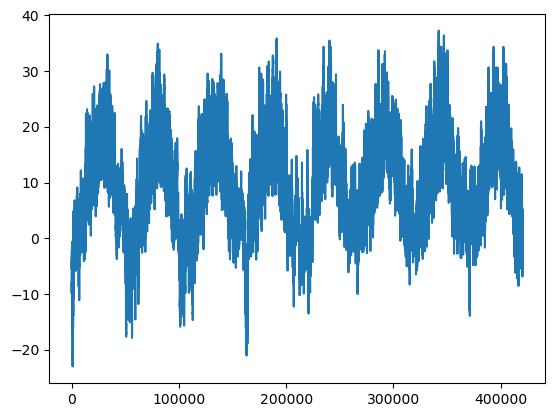

In [4]:
plt.plot(range(len(temperature)), temperature)

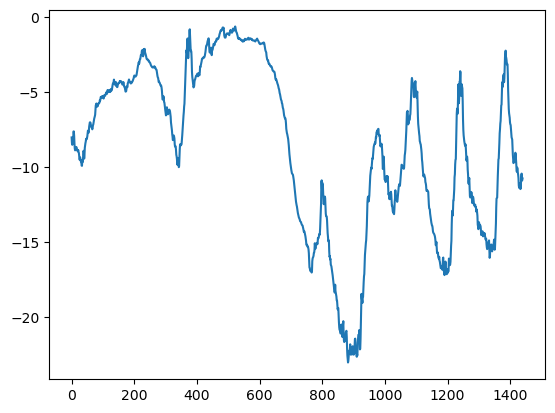

In [14]:
# Ten days temperature changes
plt.plot(range(1440), temperature[:1440]);

### Modeling

In [5]:
num_train_samples = int(.5 * len(raw_data))
num_val_samples = int(.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation samples: {num_val_samples}")
print(f"Number of test samples: {num_test_samples}")


Number of training samples: 210225
Number of validation samples: 105112
Number of test samples: 105114


In [6]:
# Normalization
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

* Given we training the model using the data of first five days recorded in hours, could we forecast the temperature the next 24 hours?

In [7]:
# Sampling rate: 1hr, 6 ten minutes
sampling_rate = 6
# Five days (24*5)
sequence_length = 120
# -1 since the index starts at 0
delay = sampling_rate * (sequence_length + 24 - 1)
# Batch
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples+num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples+num_val_samples,
)



2024-01-03 19:09:09.970895: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-03 19:09:09.970920: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-03 19:09:09.970926: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-03 19:09:09.970960: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-03 19:09:09.970980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
for samples, targets in train_dataset:
    print('Samples shape:', samples.shape)
    print('Targets shape:', targets.shape)
    break

Samples shape: (256, 120, 14)
Targets shape: (256,)


#### Set a baseline using MAE

In [28]:
def evaluate_navie_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_navie_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_navie_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [30]:
raw_data.shape

(420451, 14)

In [32]:
# Create a simple dense connected model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(16, activation='relu')(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callback = [
    keras.callbacks.ModelCheckpoint('jena_dense.keras_', save_best_only=True)
]
model.compile(
    optimizer='rmsprop',
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callback
)

Epoch 1/10


2024-01-01 10:31:13.842488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - ETA: 0s - loss: 64.0853 - mae: 6.6147

2024-01-01 10:31:23.435852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: jena_dense.keras_/assets


INFO:tensorflow:Assets written to: jena_dense.keras_/assets


819/819 [==============================] - 14s 17ms/step - loss: 64.0853 - mae: 6.6147 - val_loss: 88.7080 - val_mae: 7.5391
Epoch 2/10
817/819 [============================>.] - ETA: 0s - loss: 35.1799 - mae: 4.2614INFO:tensorflow:Assets written to: jena_dense.keras_/assets


INFO:tensorflow:Assets written to: jena_dense.keras_/assets


819/819 [==============================] - 15s 19ms/step - loss: 35.1393 - mae: 4.2587 - val_loss: 10.7729 - val_mae: 2.5504
Epoch 3/10
819/819 [==============================] - 16s 19ms/step - loss: 34.9146 - mae: 4.1599 - val_loss: 11.2949 - val_mae: 2.6358
Epoch 4/10
819/819 [==============================] - 16s 19ms/step - loss: 31.2839 - mae: 4.0389 - val_loss: 10.8032 - val_mae: 2.5738
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 30.2549 - mae: 4.1551 - val_loss: 23.0507 - val_mae: 3.8395
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 28.9951 - mae: 4.1396 - val_loss: 14.5262 - val_mae: 3.0116
Epoch 7/10
819/819 [==============================] - 13s 16ms/step - loss: 28.9722 - mae: 4.2356 - val_loss: 26.4439 - val_mae: 4.1972
Epoch 8/10
819/819 [==============================] - 14s 16ms/step - loss: 28.9706 - mae: 4.2503 - val_loss: 40.6159 - val_mae: 5.1844
Epoch 9/10
819/819 [==============================] - 13s 1

In [33]:
# Evaluation by loading the best model
model =  keras.models.load_model('jena_dense.keras_')
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

  7/405 [..............................] - ETA: 3s - loss: 11.5385 - mae: 2.6987  

2024-01-01 10:33:39.198926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


405/405 [==============================] - 4s 10ms/step - loss: 12.2846 - mae: 2.7756
Test MAE: 2.78


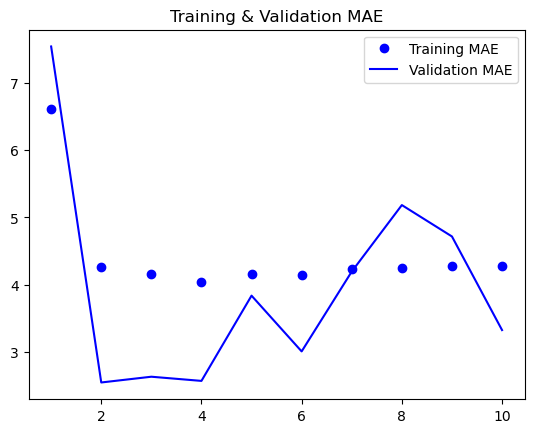

In [35]:
# Plot the resulte
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training MAE')
plt.plot(epochs, val_loss, 'b', label='Validation MAE')
plt.title("Training & Validation MAE")
plt.legend();


#### Conv1D

In [36]:
# Define a Conv1D model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.Conv1D(8, 24, activation='relu')(inputs)
x = keras.layers.MaxPool1D(2)(x)
x = keras.layers.Conv1D(8, 12, activation='relu')(inputs) # After maxpooling, the window(kernel size) becomes 12
x = keras.layers.MaxPool1D(2)(x)
x = keras.layers.Conv1D(8, 6, activation='relu')(inputs)
x = keras.layers.GlobalAveragePooling1D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Compile
callback = [keras.callbacks.ModelCheckpoint("jena_conv1d.keras_", save_best_only=True)]
model.compile(
    optimizer='rmsprop',
    loss='mse',
    metrics=['mae']
)
# Training
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callback
)

Epoch 1/10


2024-01-01 10:57:11.497926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - ETA: 0s - loss: 30.9806 - mae: 4.3392

2024-01-01 10:57:22.199365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: jena_conv1d.keras_/assets


INFO:tensorflow:Assets written to: jena_conv1d.keras_/assets


819/819 [==============================] - 15s 18ms/step - loss: 30.9806 - mae: 4.3392 - val_loss: 22.1127 - val_mae: 3.6823
Epoch 2/10
817/819 [============================>.] - ETA: 0s - loss: 22.6568 - mae: 3.8037INFO:tensorflow:Assets written to: jena_conv1d.keras_/assets


INFO:tensorflow:Assets written to: jena_conv1d.keras_/assets


819/819 [==============================] - 15s 19ms/step - loss: 22.6559 - mae: 3.8037 - val_loss: 21.2708 - val_mae: 3.6446
Epoch 3/10
819/819 [==============================] - ETA: 0s - loss: 21.9960 - mae: 3.7471INFO:tensorflow:Assets written to: jena_conv1d.keras_/assets


INFO:tensorflow:Assets written to: jena_conv1d.keras_/assets


819/819 [==============================] - 14s 17ms/step - loss: 21.9960 - mae: 3.7471 - val_loss: 20.7353 - val_mae: 3.5870
Epoch 4/10
818/819 [============================>.] - ETA: 0s - loss: 21.5498 - mae: 3.7108INFO:tensorflow:Assets written to: jena_conv1d.keras_/assets


INFO:tensorflow:Assets written to: jena_conv1d.keras_/assets


819/819 [==============================] - 14s 17ms/step - loss: 21.5469 - mae: 3.7105 - val_loss: 20.1432 - val_mae: 3.5364
Epoch 5/10
815/819 [============================>.] - ETA: 0s - loss: 21.2071 - mae: 3.6816INFO:tensorflow:Assets written to: jena_conv1d.keras_/assets


INFO:tensorflow:Assets written to: jena_conv1d.keras_/assets


819/819 [==============================] - 13s 16ms/step - loss: 21.2018 - mae: 3.6813 - val_loss: 19.9948 - val_mae: 3.5317
Epoch 6/10
817/819 [============================>.] - ETA: 0s - loss: 20.8844 - mae: 3.6523INFO:tensorflow:Assets written to: jena_conv1d.keras_/assets


INFO:tensorflow:Assets written to: jena_conv1d.keras_/assets


819/819 [==============================] - 13s 16ms/step - loss: 20.8837 - mae: 3.6523 - val_loss: 19.7581 - val_mae: 3.5128
Epoch 7/10
818/819 [============================>.] - ETA: 0s - loss: 20.5981 - mae: 3.6276INFO:tensorflow:Assets written to: jena_conv1d.keras_/assets


INFO:tensorflow:Assets written to: jena_conv1d.keras_/assets


819/819 [==============================] - 13s 16ms/step - loss: 20.6002 - mae: 3.6278 - val_loss: 19.6175 - val_mae: 3.5228
Epoch 8/10
817/819 [============================>.] - ETA: 0s - loss: 20.3654 - mae: 3.6079INFO:tensorflow:Assets written to: jena_conv1d.keras_/assets


INFO:tensorflow:Assets written to: jena_conv1d.keras_/assets


819/819 [==============================] - 13s 16ms/step - loss: 20.3658 - mae: 3.6080 - val_loss: 19.0836 - val_mae: 3.4556
Epoch 9/10
815/819 [============================>.] - ETA: 0s - loss: 20.1558 - mae: 3.5901INFO:tensorflow:Assets written to: jena_conv1d.keras_/assets


INFO:tensorflow:Assets written to: jena_conv1d.keras_/assets


819/819 [==============================] - 14s 16ms/step - loss: 20.1532 - mae: 3.5898 - val_loss: 18.9887 - val_mae: 3.4429
Epoch 10/10
813/819 [============================>.] - ETA: 0s - loss: 19.9477 - mae: 3.5723INFO:tensorflow:Assets written to: jena_conv1d.keras_/assets


INFO:tensorflow:Assets written to: jena_conv1d.keras_/assets


819/819 [==============================] - 13s 16ms/step - loss: 19.9534 - mae: 3.5728 - val_loss: 18.9745 - val_mae: 3.4504


In [37]:
# Evaluation by loading the best model
model = keras.models.load_model('jena_conv1d.keras_')
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

  7/405 [..............................] - ETA: 3s - loss: 20.4264 - mae: 3.5996  

2024-01-01 10:59:34.786902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


405/405 [==============================] - 4s 10ms/step - loss: 21.5272 - mae: 3.6738
Test MAE: 3.67


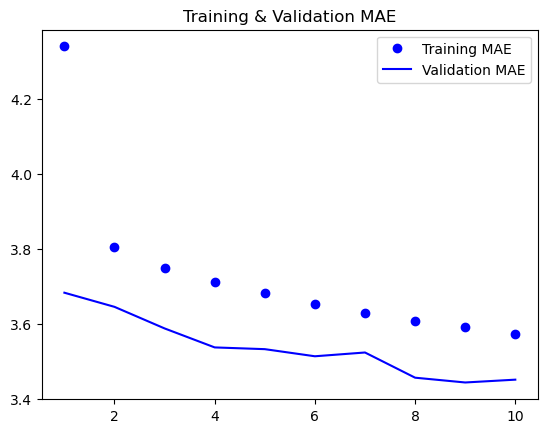

In [38]:
# Plot the resulte
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training MAE')
plt.plot(epochs, val_loss, 'b', label='Validation MAE')
plt.title("Training & Validation MAE")
plt.legend();


#### RNN as baseline using LSTM

In [39]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.LSTM(16)(inputs) # An LSTM layer with 16 neurons
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callback = [keras.callbacks.ModelCheckpoint('jena_lstm.keras_', save_best_only=True)]
model.compile(
    optimizer='rmsprop',
    loss='mse',
    metrics=['mae']
)
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callback
)

Epoch 1/10


2024-01-01 11:05:58.075021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-01 11:05:58.302479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-01 11:05:58.717986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - ETA: 0s - loss: 44.0010 - mae: 4.8473

2024-01-01 11:06:16.615613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-01 11:06:16.748273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: jena_lstm.keras_/assets


INFO:tensorflow:Assets written to: jena_lstm.keras_/assets


819/819 [==============================] - 24s 27ms/step - loss: 44.0010 - mae: 4.8473 - val_loss: 12.7967 - val_mae: 2.6976
Epoch 2/10
818/819 [============================>.] - ETA: 0s - loss: 11.1490 - mae: 2.5921INFO:tensorflow:Assets written to: jena_lstm.keras_/assets


INFO:tensorflow:Assets written to: jena_lstm.keras_/assets


819/819 [==============================] - 21s 26ms/step - loss: 11.1466 - mae: 2.5918 - val_loss: 9.7057 - val_mae: 2.4206
Epoch 3/10
818/819 [============================>.] - ETA: 0s - loss: 9.9148 - mae: 2.4562INFO:tensorflow:Assets written to: jena_lstm.keras_/assets


INFO:tensorflow:Assets written to: jena_lstm.keras_/assets


819/819 [==============================] - 22s 27ms/step - loss: 9.9151 - mae: 2.4562 - val_loss: 9.5663 - val_mae: 2.3965
Epoch 4/10
819/819 [==============================] - ETA: 0s - loss: 9.4489 - mae: 2.4018INFO:tensorflow:Assets written to: jena_lstm.keras_/assets


INFO:tensorflow:Assets written to: jena_lstm.keras_/assets


819/819 [==============================] - 23s 27ms/step - loss: 9.4489 - mae: 2.4018 - val_loss: 9.5460 - val_mae: 2.3877
Epoch 5/10
819/819 [==============================] - 21s 26ms/step - loss: 9.1531 - mae: 2.3642 - val_loss: 9.5747 - val_mae: 2.4018
Epoch 6/10
819/819 [==============================] - 21s 25ms/step - loss: 8.9653 - mae: 2.3387 - val_loss: 9.7767 - val_mae: 2.4274
Epoch 7/10
819/819 [==============================] - 21s 26ms/step - loss: 8.7651 - mae: 2.3094 - val_loss: 9.7851 - val_mae: 2.4314
Epoch 8/10
819/819 [==============================] - 21s 26ms/step - loss: 8.5269 - mae: 2.2763 - val_loss: 9.8444 - val_mae: 2.4431
Epoch 9/10
819/819 [==============================] - 21s 25ms/step - loss: 8.2648 - mae: 2.2393 - val_loss: 9.8604 - val_mae: 2.4530
Epoch 10/10
819/819 [==============================] - 21s 25ms/step - loss: 8.0559 - mae: 2.2076 - val_loss: 10.0777 - val_mae: 2.4741


In [40]:
# Evaluation by loading the best model
model = keras.models.load_model('jena_lstm.keras_')
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

2024-01-01 11:10:00.019580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-01 11:10:00.153219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


405/405 [==============================] - 5s 11ms/step - loss: 10.2886 - mae: 2.5145
Test MAE: 2.51


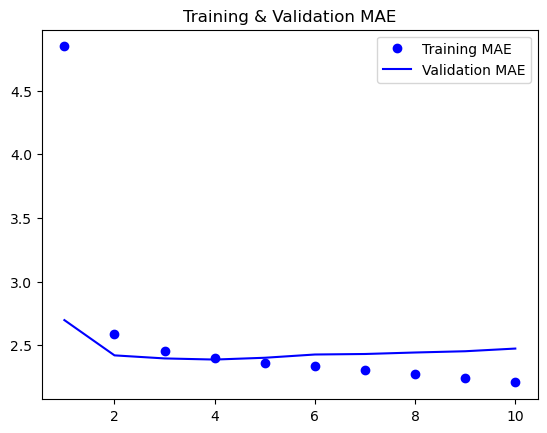

In [41]:
# Plot the resulte
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training MAE')
plt.plot(epochs, val_loss, 'b', label='Validation MAE')
plt.title("Training & Validation MAE")
plt.legend();


# How RNN Works and techniques to optimize it

In [ ]:
# Initial state
state_t = 0

# Iteration
for input_t in input_sequence:
    output_t = f(input_t, state_t) # f() is activation function
    state_t = output_t

# Iteration in detail
for input_t in input_sequence:
    output_t = f(dot(W, input_t) + dot(U, state_t) + b) # f() is activation function
    state_t = output_t

In [4]:
# Simple RNN architecture

timesteps = 100
input_feature = 32
output_feature = 64
inputs = np.random.random((timesteps, input_feature))
state_t = np.zeros((output_feature,))
W = np.random.random((output_feature, input_feature))
U = np.random.random((output_feature, output_feature))
b = np.random.random((output_feature,))
successive_outputs = []

for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b) # Using Tanh as activation function
    successive_outputs.append(output_t)
    # Update state
    state_t = output_t

# successive_outputs is a 2D tensor with shape (timesteps, output_feature)
final_output_seqence = np.stack(successive_outputs, axis=0)

In [ ]:
# The above architecture in Keras
num_features = 14
inputs = keras.Input(shape = (None, num_features)) # Using None so that the input sequence can be any time length, which is quite useful when the length of the input seqence is all different
outputs = keras.layers.SimpleRNN(16)(inputs)

In [9]:
# The RNN only returns the final output
num_features = 14
steps = 120
inputs = keras.Input(shape = (steps, num_features))
outputs = keras.layers.SimpleRNN(16, return_sequences=False)(inputs) # return_sequences=False is the default setting
print(f"Output shape: {outputs.shape}")

2024-01-02 21:12:35.233351: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-02 21:12:35.233380: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-02 21:12:35.233387: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-02 21:12:35.233780: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-02 21:12:35.234132: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Output shape: (None, 16)


In [10]:
# The RNN returns the complete output sequence from t=0 to t
num_features = 14
steps = 120 # t
inputs = keras.Input(shape = (steps, num_features))
outputs = keras.layers.SimpleRNN(16, return_sequences=True)(inputs) # return_sequences=False is the default setting
print(f"Output shape: {outputs.shape}")

Output shape: (None, 120, 16)


In [ ]:
# Sometimes, stack the output of each RNN layer can improve the representation power of the model
num_features = 14
inputs = keras.Input(shape = (None, num_features)) 
x = keras.layers.SimpleRNN(16, return_sequences=True)(inputs) # By setting return_sequences=True
x = keras.layers.SimpleRNN(16, return_sequences=True)(x)
outputs = keras.layers.SimpleRNN(16)(x)

## Using Recurrent Dropout

In [ ]:
# Create a more complicated LSTM model
inputs = keras.Input(shape=(sequence_length, 14))
x = keras.layers.LSTM(32, recurrent_dropout=.25, unroll=True)(inputs) # Add recurrent dropout unit that will drop out 25% units # Add unroll=True to speed up the training without cuDNN
x = keras.layers.Dropout(.5)(x) # Regularization for the dense layer by adding a normal dropout layer
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callback = [keras.callbacks.ModelCheckpoint('jena_lstm_dropout.keras_', save_best_only=True)]
model.compile(
    optimizer='rmsprop',
    loss='mse',
    metrics=['mae']
)
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callback
)

## Stack the recurrent layer

In [11]:
# Create a GRU model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.GRU(32, recurrent_dropout=.5, return_sequences=True, unroll=True)(inputs) # Add recurrent dropout unit that will drop out 25% units # Add unroll=True to speed up the training without cuDNN
x = keras.layers.GRU(32, recurrent_dropout=.5, unroll=True)(x)
x = keras.layers.Dropout(.5)(x) # Regularization for the dense layer by adding a normal dropout layer
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callback = [keras.callbacks.ModelCheckpoint('jena_lstm_gru_dropout.keras_', save_best_only=True)]
model.compile(
    optimizer='rmsprop',
    loss='mse',
    metrics=['mae']
)
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callback
)

Epoch 1/50


ValueError: in user code:

    File "/opt/homebrew/Caskroom/miniforge/base/envs/deep/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/deep/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/deep/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/deep/lib/python3.10/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/deep/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/Caskroom/miniforge/base/envs/deep/lib/python3.10/site-packages/keras/src/backend.py", line 4858, in rnn
        raise ValueError("Unrolling requires a fixed number of timesteps.")

    ValueError: Exception encountered when calling layer 'gru_2' (type GRU).
    
    Unrolling requires a fixed number of timesteps.
    
    Call arguments received by layer 'gru_2' (type GRU):
      • inputs=tf.Tensor(shape=(None, None, 14), dtype=float32)
      • mask=None
      • training=True
      • initial_state=None
